# Calculation of phase equilbrium

This notebook outlines how to calculate phase equilbrium in the slurry zone. We
assume a two component system (Fe and O) with one or two phases (solid and/or
liquid) and need to be able to calculate the equilbrium volume fraction of solid
and liquid, and the composition (oxygen fraction) of both phases as a function of
pressure, temperature, and bulk composition. There are two ways to proceed:

1. Parameterise the phase diagram and apply the lever rule.
2. Parameterise the free energy and undertake free energy minimisation

Option 1 is simple and should be quick to implement. Option 2 is more general 
(e.g. it would be easy to move to a three component system) and has the advantage
of also giving the difference in free energy between the solid and the liquid. This
is needed as part of classical neucleation theory and some crystal growth theories. If
we do have the free energy we can thus make the whole thing (more) self consistent.

For now we'll start with 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import phase_equilibrium

## Lever rule

The 330 GPa phase diagram from Figure 6 of Komabayashi (2014; 
http://dx.doi.org/10.1002/2014JB010980) looks appropreate, easy
to implement, and seems to match DFT predictions. This is based
on experiments and ideal solution theory. Key parameters are:

* Pure Fe melting temperature: $\sim$6400 K
* Eutectic temperature: $\sim$4400 K
* Eutectic composition: $\sim$9 wt.% O
* FeO melting temperature: $\sim$6000 K
* Both solid FeO and Fe are phase pure (no O in Fe, $\sim$ 23 wt.% O in FeO.
* Liquidus above and below the eutectic is a straight line.

We'll assume we only care about 330 GPa and for a given temperature and bulk
composition work out where we are in relation to the points above before
calculating the composition and proportions of the phases.

In [3]:
x = 0.04

for t in [6500, 6000, 5000, 4500, 4400]:
    x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus = \
        phase_equilibrium.phase_relations_komabayashi2004(t,x)
    print("Temperature:", t, "K, bulk O wt. frac:", x)
    print("Weight frac solid Fe:", phi_fe)
    print("Weight frac solid FeO:", phi_feo)
    print("Weight frac liquid:", phi_lq)
    print("O wt. frac in liquid:", x_lq)
    print()


Temperature: 6500 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.0
Weight frac solid FeO: 0.0
Weight frac liquid: 1.0
O wt. frac in liquid: 0.04

Temperature: 6000 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.0
Weight frac solid FeO: 0.0
Weight frac liquid: 1.0
O wt. frac in liquid: 0.04

Temperature: 5000 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.36507936507936506
Weight frac solid FeO: 0.0
Weight frac liquid: 0.6349206349206349
O wt. frac in liquid: 0.063

Temperature: 4500 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.5321637426900584
Weight frac solid FeO: 0.0
Weight frac liquid: 0.4678362573099416
O wt. frac in liquid: 0.08549999999999999

Temperature: 4400 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.8203861697350696
Weight frac solid FeO: 0.17961383026493039
Weight frac liquid: 0.0
O wt. frac in liquid: nan



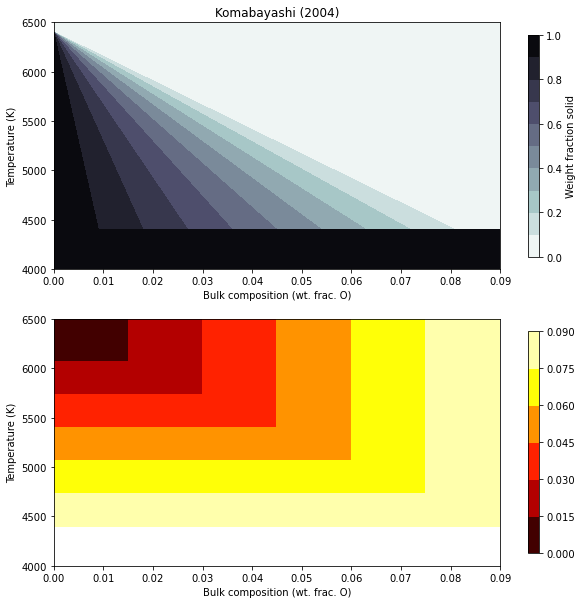

In [4]:
# Grid of points to calculate weight fraction
ts, xs = np.meshgrid(np.linspace(4000, 6500, 2200),
                     np.linspace(0.0, 0.09, 500))

# Total weight fraction solid
frac_solid_fe = phase_equilibrium.total_solid_fraction(ts, xs)
x_lq = phase_equilibrium.liquid_o_wt_fraction(ts, xs) 

# Graph the result
fig, ax = plt.subplots(nrows=2, figsize=(10,10))
h = ax[0].contourf(xs, ts, frac_solid_fe, 
                   cmap=plt.cm.bone_r,
                   levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar = fig.colorbar(h, ax=ax[0], shrink=0.9)
ax[0].set_title("Komabayashi (2004)")
cbar.ax.set_ylabel("Weight fraction solid")
ax[0].set_ylabel("Temperature (K)")
ax[0].set_xlabel("Bulk composition (wt. frac. O)")

h = ax[1].contourf(xs, ts, x_lq, 
                   cmap=plt.cm.hot)
cbar = fig.colorbar(h, ax=ax[1], shrink=0.9)

ax[1].set_ylabel("Liquid composition (wt. frac. )")
ax[1].set_ylabel("Temperature (K)")
ax[1].set_xlabel("Bulk composition (wt. frac. O)")

plt.show()

## Free Energy Minimisation

The idea is quite general and could cope with more than one solid phase and mor
than two components. I'll try and point out any assumptions as I go. This is 
all based on the `two_phase_phase_transition` notebook from LEMA's `common_tangent`
branch. That needs cleaning up and merging properly!

As input, we assume we know the free energy of the solid and liquid phases,
as a function of pressure, $P$, temperature $T$, and oxygen content, $x$. The total free energy
of a mixture of solid and liquid is then given by:

$$G(P,T,X) = \phi G_s(P,T,x_s) + (1 - \phi) G_l(P,T,x_l)$$

where $G_s$ is the free energy of the solid $G_l$ is the free
energy of the liquid, and $\phi$ is the fraction of the material that is solid. Here we assume that
the temperature and pressure of the two phases is equal, and we neglect surface energy or any
contribution from the way the solid is arranged in the liquid (or vice versa). We allow the composition
of the solid and liquid to be different.

At (phase) equilbrium, the volume fraction is fixed (solids neither grow or dissolve) because 
the free energy
is at a minimim. There are three cases: liquid only at temperatures above the liquidus, solid only
at temperatures below the solidus, and a two phase region inbetween that only exists if $X > 0$.

Inside the two phase region, the free energy of the mixture is lower than the free energy
of either phase with the same overall composition. The two-phase region can be found by 
constructing the common tangent of two free energy curves, the two phase mixture is in
equilibrium between the two points where tangent touches the free energy curves. However,
we will avoid this graphical solution and proceed numerically.

Assuming we have functions for $G_s(P,T,x_s)$ and $G_l(P,T,x_l)$, (see below) we can find
$x_s$, $x_l$ and $\phi$ by minimising the free energy of the system subject to the constraint
that the solid and liquid phases are in equilibrium (that is, they have the same chemical potential):

$$ \frac{\mathrm{d}G_s(P,T,x_s)}{\mathrm{d}x}\Bigr|_{x=x_s} = 
        \frac{\mathrm{d}G_l(P,T,x_l)}{\mathrm{d}x}\Bigr|_{x=x_l} $$
        
and that the total composition of the system, $X$, is fixed:

$$ X = \phi x_s + (1 - \phi) x_l $$

If we choose a value for $X$, a pressure, and a temperature that is inside the two phase region,
minimising $G$ as a function $x_l$, $x_s$ and $\phi$,  subject to these 
constraints will yield a description of the equilbrium assemblage. We can then use this to 
construct a phase diagram or the physical properties of the mixed phase region.

In general this can turn out to be quite a nasty nonlinear constrained minimisation problem,
but with reasonable initial guesses SciPy has tools that seem to work.

### Free energy of the solid and liquid

So the key input for this is two functions, $G_s(P,T,x_s)$ and $G_l(P,T,x_l)$. It seems that
a good starting point would be the case where the oxygen is the only impurity. For the solid with
$x_s = 0$, Alfe et al. (2001) should have all the data we need. For the liquid with $x_l = 0$, 
Alfe et al. (2002a) should have all the data we need. To include oxygen we should be able to
use data from Alfe et al. (2002b). However, as far as I can see the information is not easily 
available from these papers. Gubbins et al. used these results (with some extra information) to 
build a thermal evolution model with (2004) and wihout (2003) oxygen. They had free energies 
"fitted to a simple functional form of volume and temperature" (2003; after equation 75) and this
functional form is a polynomial (2003; after equation 82). However, neither the polynomial or the
coefficients seem to be provided in the paper. Instead, I'll try and cobble something together
from the information that is given trying to make the sources of error clear.

***See notes on back of purple paper printout***



#### References

D. Alfe, G. D. Price, and M. J. Gillan. Thermodynamics of hexagonal-close-packed iron under Earth’s core conditions. Physical Review B, 64, 2001.

D. Alfe, G. D. Price, and M. J. Gillan. Iron under Earth’s core conditions: Liquid-state thermodynamics and high-pressure melting curve from ab initio calculations. Physical Review B, 65:165118, 2002a.

D. Alfe, G. D. Price, and M. J. Gillan. ab initio chemical potentials of solid and liquid solutions and the chemistry of the Earth’s core. Journal of Chemical Physics, 116:7127 – 7136, 2002b.

D. Gubbins, D. Alfe, G. Masters, G. D. Price, and M. J. Gillan. Can the earth’s dynamo run on heat alone? Geophysical Journal International, 115:609 – 622, 2003.

D. Gubbins, D. Alfe, G. Masters, G. D. Price, and M. Gillan. Gross thermodynamics of two-component core convection. Geophysical Journal International, 157:1407 – 1414, 2004.

In [5]:
def free_energy_solid(x_s, t, p):
    pass
    
def free_energy_liquid(x_l, t, p):
    pass